# Projet 6 - Réalisez une analyse de sentiments grâce au Deep Learning

> 🎓 OpenClassrooms • Parcours [AI Engineer](https://openclassrooms.com/fr/paths/795-ai-engineer) | 👋 *Étudiant* : [David Scanu](https://www.linkedin.com/in/davidscanu14/)

## 📝 Contexte

Dans le cadre de ma formation d'AI Engineer chez OpenClassrooms, ce projet s'inscrit dans un scénario professionnel où j'interviens en tant qu'ingénieur IA chez MIC (Marketing Intelligence Consulting), entreprise de conseil spécialisée en marketing digital.

Notre client, Air Paradis (compagnie aérienne), souhaite **anticiper les bad buzz sur les réseaux sociaux**. La mission consiste à développer un produit IA permettant de **prédire le sentiment associé à un tweet**, afin d'améliorer la gestion de sa réputation en ligne.

## ⚡ Mission

> Développer un modèle d'IA permettant de prédire le sentiment associé à un tweet.

Créer un prototype fonctionnel d'un modèle d'**analyse de sentiments pour tweets** selon trois approches différentes :

1. **Modèle sur mesure simple** : Approche classique (régression logistique) pour une prédiction rapide
2. **Modèle sur mesure avancé** : Utilisation de réseaux de neurones profonds avec différents word embeddings
3. **Modèle avancé BERT** : Exploration de l'apport en performance d'un modèle BERT

Cette mission implique également la mise en œuvre d'une démarche MLOps complète :
- Utilisation de MLFlow pour le tracking des expérimentations et le stockage des modèles
- Création d'un pipeline de déploiement continu (Git + Github + plateforme Cloud)
- Intégration de tests unitaires automatisés
- Mise en place d'un suivi de performance en production via Azure Application Insight

## 🗓️ Plan de travail

1. **Exploration et préparation des données**
   - Acquisition des données de tweets Open Source
   - Analyse exploratoire et prétraitement des textes

2. **Développement des modèles**
   - Implémentation du modèle classique (régression logistique)
   - Conception du modèle avancé avec différents word embeddings
   - Test du modèle BERT pour l'analyse de sentiments
   - Comparaison des performances via MLFlow

3. **Mise en place de la démarche MLOps**
   - Configuration de MLFlow pour le tracking des expérimentations
   - Création du dépôt Git avec structure de projet appropriée
   - Implémentation des tests unitaires automatisés
   - Configuration du pipeline de déploiement continu

4. **Déploiement et monitoring**
   - Développement de l'API de prédiction avec FastAPI
   - Déploiement sur Heroku
   - Création de l'interface de test (Streamlit ou Next.js)
   - Configuration du suivi via Azure Application Insight

5. **Communication**
   - Rédaction de l'article de blog
   - Préparation du support de présentation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import zipfile
import os
import re
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import datetime

## 💾 Jeu de données : Sentiment140

Le jeu de données [Sentiment140 dataset with 1.6 million tweets](https://www.kaggle.com/datasets/kazanova/sentiment140) est une ressource majeure pour l'analyse de sentiment sur Twitter, comprenant **1,6 million de tweets** extraits via l'API Twitter. Ces tweets ont été automatiquement annotés selon leur polarité sentimentale, offrant une base solide pour développer des modèles de classification de sentiment.

Le jeu de données est organisé en 6 colonnes distinctes :

1. **target** : La polarité du sentiment exprimé dans le tweet.
   - 0 = sentiment négatif
   - 2 = sentiment neutre
   - 4 = sentiment positif
2. **ids** : L'identifiant unique du tweet (exemple : *2087*)
3. **date** : La date et l'heure de publication du tweet.
4. **flag** : La requête utilisée pour obtenir le tweet.
   - Exemple : *lyx*
   - Si aucune requête n'a été utilisée : *NO_QUERY*
5. **user** : Le nom d'utilisateur de l'auteur du tweet.
6. **text** : Le contenu textuel du tweet.

In [3]:
%%time 

# Define the URL and the local file path
url = "https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+7%C2%A0-+D%C3%A9tectez+les+Bad+Buzz+gr%C3%A2ce+au+Deep+Learning/sentiment140.zip"
local_zip_path = "./content/data/sentiment140.zip"
extract_path = "./content/data"

if not os.path.exists(extract_path):

    # Create the directory if it doesn't exist
    os.makedirs(extract_path, exist_ok=True)

    # Download the zip file
    response = requests.get(url)
    with open(local_zip_path, 'wb') as file:
        file.write(response.content)

    # Extract the contents of the zip file
    with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    # Delete the zip file
    os.remove(local_zip_path)

CPU times: user 44 μs, sys: 3 μs, total: 47 μs
Wall time: 50.5 μs


In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

In [5]:

# Define the path to the CSV file
csv_file_path = os.path.join(extract_path, 'training.1600000.processed.noemoticon.csv')

# Define the column names
column_names = ['target', 'ids', 'date', 'flag', 'user', 'text']

# Load the dataset into a pandas DataFrame
df = pd.read_csv(csv_file_path, encoding='latin-1', names=column_names)

# Display the first few rows of the DataFrame
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
print(f"Ce dataframe contient {df.shape[1]} colonnes et {df.shape[0]} lignes.")

Ce dataframe contient 6 colonnes et 1600000 lignes.


## 🔬 Analyse exploratoire des données Sentiment140

Pour bien comprendre votre jeu de données Sentiment140 et optimiser votre modèle d'analyse de sentiment, je vous propose une analyse exploratoire complète qui couvre les aspects suivants :

1. **Aperçu général du jeu de données**
   - Distribution des classes de sentiment
   - Vérification des valeurs manquantes et doublons
   - Structure générale du DataFrame

2. **Analyse de la distribution des sentiments**
   - Visualisation de l'équilibre/déséquilibre des classes
   - Répartition des sentiments positifs et négatifs

3. **Analyse temporelle**
   - Distribution des tweets dans le temps
   - Patterns temporels par sentiment
   - Analyse par heure, jour, mois

4. **Analyse du contenu textuel**
   - Longueur des tweets (caractères et mots)
   - Distribution des longueurs par sentiment
   - Complexité linguistique

5. **Analyse des mots fréquents**
   - Nuages de mots pour chaque classe de sentiment
   - Mots discriminants entre sentiments positifs et négatifs
   - N-grammes les plus fréquents

6. **Caractéristiques distinctives**
   - Utilisation de la ponctuation
   - Ratio de majuscules
   - Présence d'émoticônes et symboles

7. **Analyse des utilisateurs**
   - Distribution des tweets par utilisateur
   - Tendances de sentiment par utilisateur

8. **Analyse des requêtes (flag)**
   - Impact des requêtes sur la distribution des sentiments
   - Requêtes les plus fréquentes

9. **Recommandations pour le prétraitement**
   - Nettoyage du texte
   - Tokenisation adaptée à Twitter
   - Gestion des mentions, hashtags et URLs

10. **Recommandations pour la modélisation**
    - Approches de vectorisation
    - Modèles recommandés
    - Stratégies d'évaluation

### Points clés à explorer

**Distribution des sentiments :** 

La première étape consistera à vérifier l'équilibre des classes. Un déséquilibre pourrait nécessiter des techniques comme le sur/sous-échantillonnage ou la pondération des classes dans votre modèle.

**Caractéristiques linguistiques :**

L'analyse des mots les plus fréquents et des caractéristiques distinctives entre tweets positifs et négatifs vous aidera à identifier des features pertinentes pour votre modèle.

**Prétraitement recommandé :**

Le code fournit des recommandations détaillées pour le prétraitement des tweets, notamment :
- Gestion des URLs, mentions et hashtags
- Normalisation du texte
- Tokenisation adaptée au langage de Twitter

**Approches de modélisation :**

Plusieurs approches sont recommandées, allant des modèles classiques (SVM, Naive Bayes) aux architectures avancées (LSTM, BERT), avec leurs avantages et inconvénients respectifs.

In [7]:
import nltk

# Télécharger les ressources NLTK nécessaires
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/david/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/david/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Informations générales sur le jeu de données 

- Distribution des classes de sentiment
- Vérification des valeurs manquantes et doublons
- Structure générale du DataFrame

In [8]:
def afficher_info_generales(df):
    """Affiche les informations générales sur le DataFrame"""
    print("1. APERÇU GÉNÉRAL DU JEU DE DONNÉES")
    print("-" * 50)
    print(f"Nombre total d'entrées: {df.shape[0]:,}")
    print(f"Nombre de colonnes: {df.shape[1]}")
    print("\nColonnes présentes:")
    for col in df.columns:
        print(f"- {col}")
    
    print("\nTypes de données:")
    print(df.dtypes)
    
    print("\nValeurs manquantes par colonne:")
    print(df.isnull().sum())
    
    # Vérifier les doublons
    duplicates = df.duplicated().sum()
    print(f"\nNombre de lignes dupliquées: {duplicates:,} ({duplicates/len(df)*100:.2f}%)")

afficher_info_generales(df)

1. APERÇU GÉNÉRAL DU JEU DE DONNÉES
--------------------------------------------------
Nombre total d'entrées: 1,600,000
Nombre de colonnes: 6

Colonnes présentes:
- target
- ids
- date
- flag
- user
- text

Types de données:
target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

Valeurs manquantes par colonne:
target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

Nombre de lignes dupliquées: 0 (0.00%)


### Analyse de la distribution des sentiments

- Visualisation de l'équilibre/déséquilibre des classes
- Répartition des sentiments positifs et négatifs



2. DISTRIBUTION DES SENTIMENTS
--------------------------------------------------
sentiment
Négatif    800000
Positif    800000
Name: count, dtype: int64

Pourcentage par catégorie:
sentiment
Négatif    50.00%
Positif    50.00%
Name: proportion, dtype: object


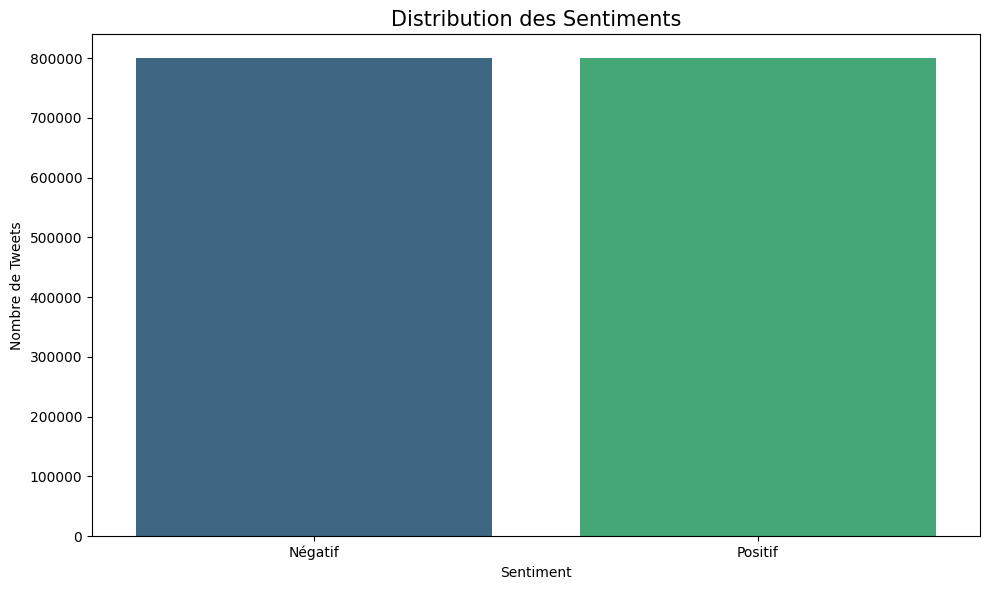

In [9]:
def analyser_distribution_sentiment(df):
    """Analyse la distribution des sentiments"""
    print("\n2. DISTRIBUTION DES SENTIMENTS")
    print("-" * 50)
    
    # Convertir les codes (0, 4) en catégories (négatif, positif)
    sentiment_map = {0: 'Négatif', 2: 'Neutre', 4: 'Positif'}
    df['sentiment'] = df['target'].map(sentiment_map)
    
    # Afficher le compte
    sentiment_counts = df['sentiment'].value_counts()
    print(sentiment_counts)
    print("\nPourcentage par catégorie:")
    print(df['sentiment'].value_counts(normalize=True).map(lambda x: f"{x*100:.2f}%"))
    
    # Visualiser la distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(x='sentiment', hue='sentiment', data=df, palette='viridis')
    plt.title('Distribution des Sentiments', fontsize=15)
    plt.xlabel('Sentiment')
    plt.ylabel('Nombre de Tweets')
    plt.tight_layout()
    plt.show()

analyser_distribution_sentiment(df)

### Détection de la langue des tweets

In [ ]:
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

# Set seed for reproducibility
DetectorFactory.seed = 0

def detect_language(text):
    """Detect the language of a given text."""
    try:
        return detect(text)
    except LangDetectException:
        return 'unknown'

# Apply language detection to the 'text' column
df['language'] = df['text'].apply(detect_language)

# Display the distribution of detected languages
language_counts = df['language'].value_counts()
print("Distribution des langues détectées:")
print(language_counts)

# Visualize the distribution of detected languages
plt.figure(figsize=(12, 6))
sns.countplot(y='language', data=df, order=language_counts.index, palette='viridis')
plt.title('Distribution des Langues Détectées', fontsize=15)
plt.xlabel('Nombre de Tweets')
plt.ylabel('Langue')
plt.tight_layout()
plt.show()

### Analyse temporelle

- Distribution des tweets dans le temps
- Patterns temporels par sentiment
- Analyse par heure, jour, mois


3. ANALYSE TEMPORELLE
--------------------------------------------------
Période couverte: de 2009-04-06 22:19:45 à 2009-06-25 10:28:31


/tmp/ipykernel_15858/2239398726.py:7: FutureWarning: Parsed string "Mon Apr 06 22:19:45 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df['date_obj'] = pd.to_datetime(df['date'], errors='coerce')


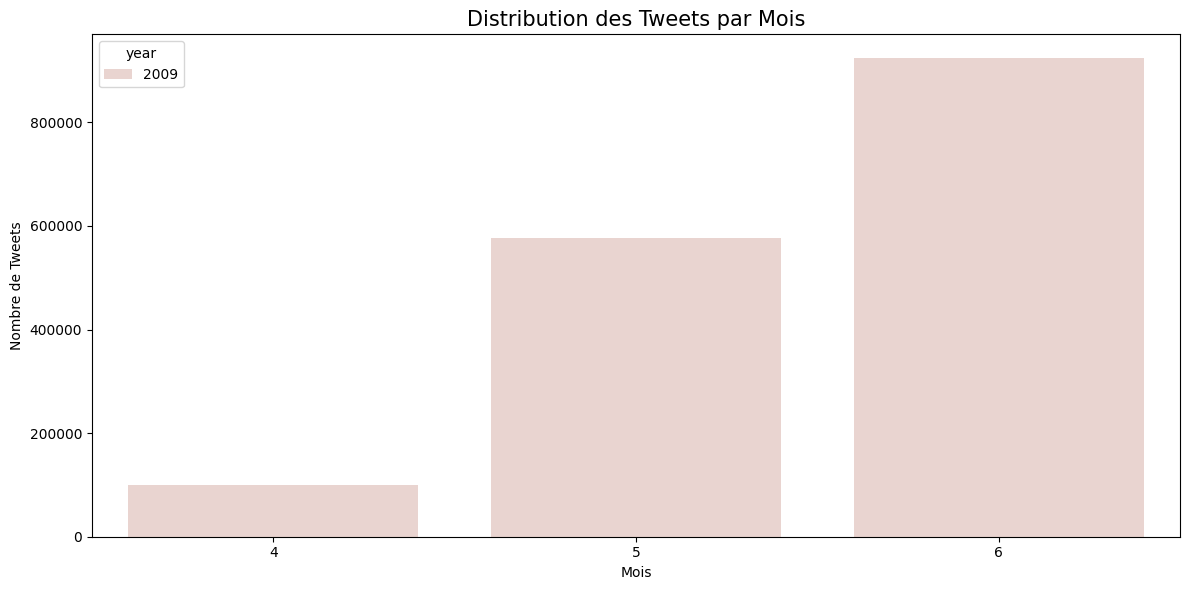

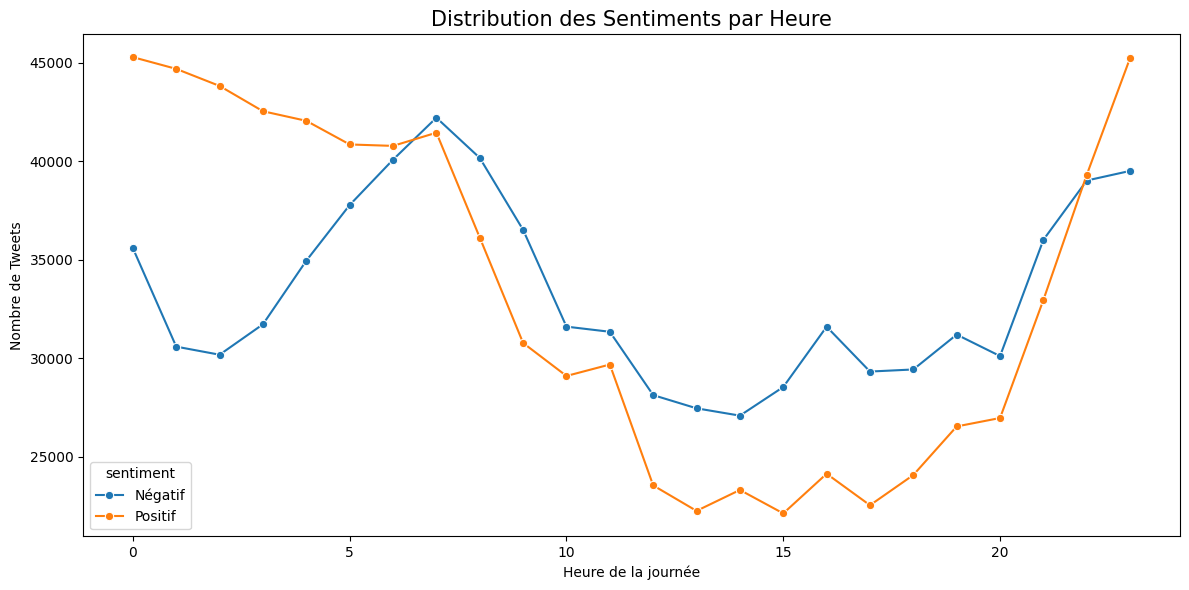

In [11]:
def analyser_temporalite(df):
    """Analyse la distribution temporelle des tweets"""
    print("\n3. ANALYSE TEMPORELLE")
    print("-" * 50)
    
    # Convertir la colonne 'date' en format datetime
    df['date_obj'] = pd.to_datetime(df['date'], errors='coerce')
    
    # Extraire les composantes de date
    df['year'] = df['date_obj'].dt.year
    df['month'] = df['date_obj'].dt.month
    df['day'] = df['date_obj'].dt.day
    df['hour'] = df['date_obj'].dt.hour
    df['weekday'] = df['date_obj'].dt.dayofweek
    
    # Afficher la plage temporelle
    print(f"Période couverte: de {df['date_obj'].min()} à {df['date_obj'].max()}")
    
    # Distribution par mois
    plt.figure(figsize=(12, 6))
    monthly_counts = df.groupby(['year', 'month']).size().reset_index(name='count')
    sns.barplot(x='month', y='count', hue='year', data=monthly_counts)
    plt.title('Distribution des Tweets par Mois', fontsize=15)
    plt.xlabel('Mois')
    plt.ylabel('Nombre de Tweets')
    plt.tight_layout()
    plt.show()
    
    # Distribution par heure de la journée
    plt.figure(figsize=(12, 6))
    hourly_sentiment = df.groupby(['hour', 'sentiment']).size().reset_index(name='count')
    sns.lineplot(x='hour', y='count', hue='sentiment', data=hourly_sentiment, marker='o')
    plt.title('Distribution des Sentiments par Heure', fontsize=15)
    plt.xlabel('Heure de la journée')
    plt.ylabel('Nombre de Tweets')
    plt.tight_layout()
    plt.show()

analyser_temporalite(df)

### Analyse du contenu textuel

- Longueur des tweets (caractères et mots)
- Distribution des longueurs par sentiment
- Complexité linguistique


4. ANALYSE DU CONTENU TEXTUEL
--------------------------------------------------
Longueur moyenne des tweets: 74.09 caractères
Nombre moyen de mots par tweet: 13.18 mots


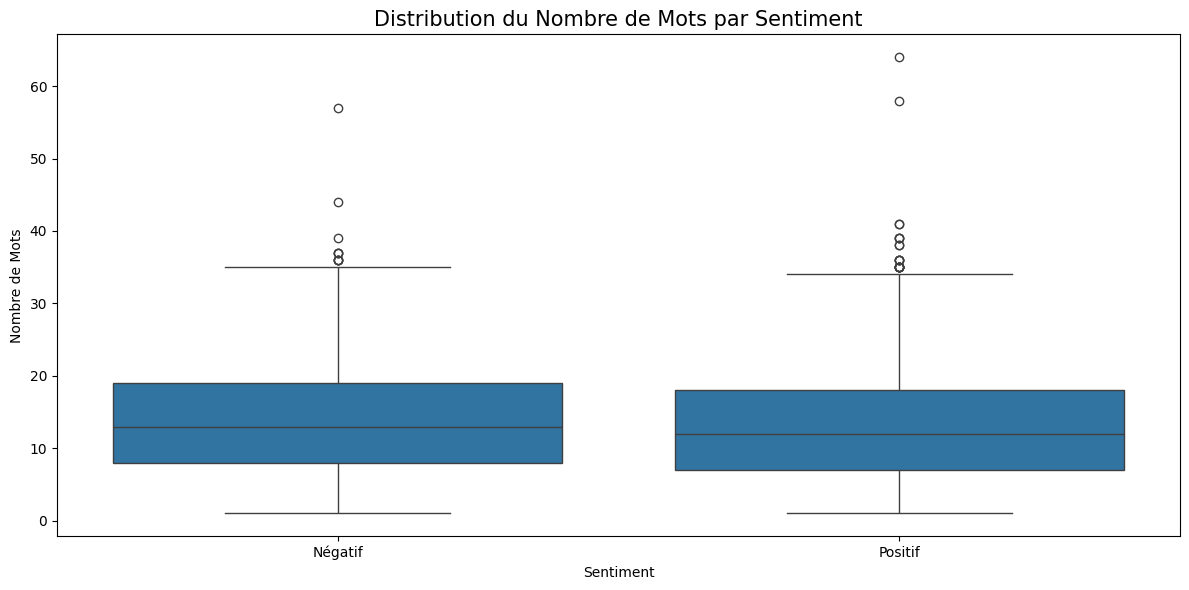

In [12]:
def analyser_texte_tweets(df):
    """Analyse les caractéristiques textuelles des tweets"""
    print("\n4. ANALYSE DU CONTENU TEXTUEL")
    print("-" * 50)
    
    # Calcul de la longueur des tweets
    df['text_length'] = df['text'].apply(len)
    df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
    
    print(f"Longueur moyenne des tweets: {df['text_length'].mean():.2f} caractères")
    print(f"Nombre moyen de mots par tweet: {df['word_count'].mean():.2f} mots")
    
    # Distribution des longueurs par sentiment
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='sentiment', y='word_count', data=df)
    plt.title('Distribution du Nombre de Mots par Sentiment', fontsize=15)
    plt.xlabel('Sentiment')
    plt.ylabel('Nombre de Mots')
    plt.tight_layout()
    plt.show()

analyser_texte_tweets(df)

### Analyse des mots fréquents

- Nuages de mots pour chaque classe de sentiment
- Mots discriminants entre sentiments positifs et négatifs
- N-grammes les plus fréquents


Mots les plus fréquents pour les tweets positifs:
- im: 74,853
- good: 60,846
- love: 46,839
- day: 44,363
- like: 37,108
- get: 36,168
- thanks: 33,723
- lol: 33,470
- going: 30,647
- time: 29,336
- today: 28,411
- go: 27,785
- got: 27,769
- new: 26,643
- one: 25,823
- see: 25,460
- know: 25,274
- great: 24,881
- well: 24,532
- back: 23,458


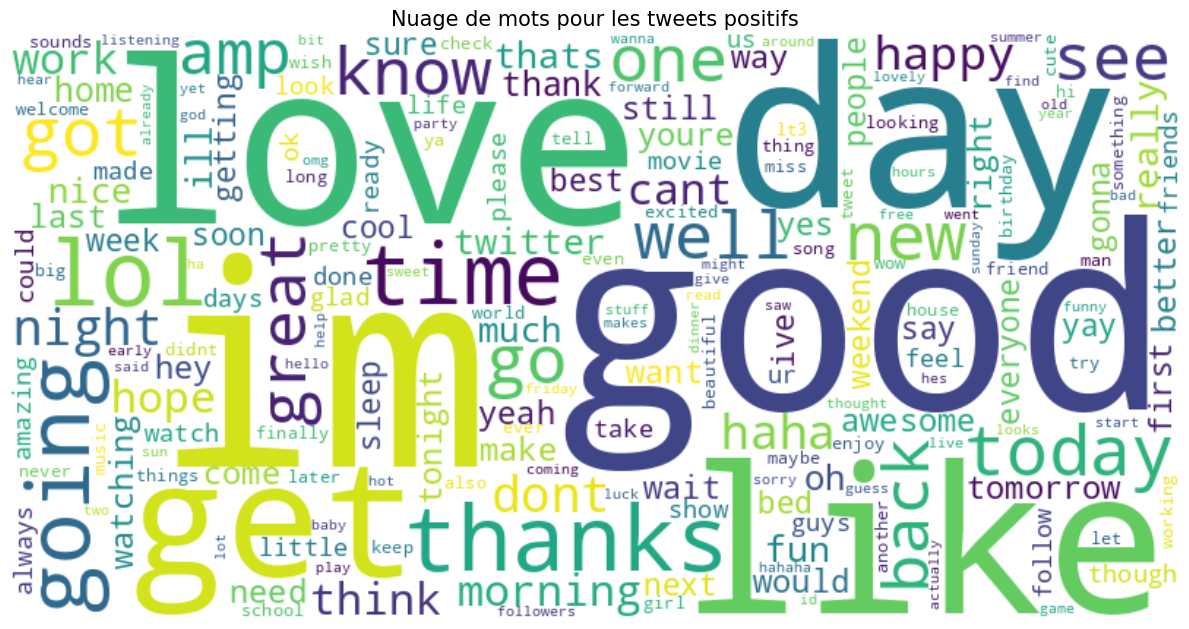


Mots les plus fréquents pour les tweets négatifs:
- im: 102,625
- get: 45,316
- go: 45,126
- dont: 44,913
- work: 44,057
- cant: 43,591
- like: 40,640
- day: 38,000
- today: 36,190
- going: 33,440
- got: 32,983
- back: 32,516
- really: 31,221
- miss: 30,500
- want: 29,732
- still: 28,758
- good: 28,552
- sad: 27,143
- time: 26,771
- one: 26,362


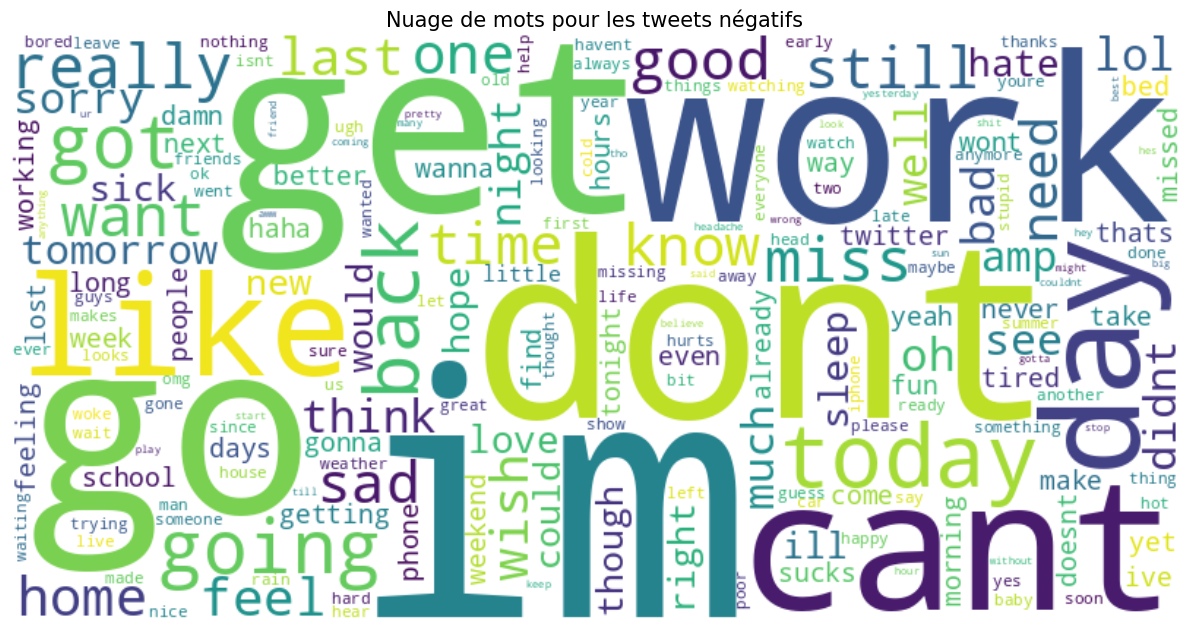

In [13]:
def analyser_mots_frequents(df, sentiment):
    """Analyse les mots les plus fréquents pour un sentiment donné"""
    # Filtrer par sentiment
    texts = df[df['sentiment'] == sentiment]['text'].astype(str)
    
    # Télécharger les stopwords si nécessaire
    stop_words = set(stopwords.words('english'))
    
    # Fonction pour nettoyer et tokenizer le texte
    def preprocess_text(text):
        # Convertir en minuscules et supprimer caractères spéciaux
        text = re.sub(r'[^\w\s]', '', text.lower())
        # Tokenizer manuellement (sans utiliser PunktTokenizer)
        tokens = text.split()
        # Supprimer les stopwords
        tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
        return tokens
    
    # Traiter tous les textes
    all_words = []
    for text in texts:
        all_words.extend(preprocess_text(text))
    
    # Compter les occurrences
    word_counts = Counter(all_words)
    most_common = word_counts.most_common(20)
    
    # Créer un nuage de mots
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(word_counts))
    
    # Afficher les résultats
    print(f"\nMots les plus fréquents pour les tweets {sentiment.lower()}s:")
    for word, count in most_common:
        print(f"- {word}: {count:,}")
    
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nuage de mots pour les tweets {sentiment.lower()}s', fontsize=15)
    plt.tight_layout()
    plt.show()

analyser_mots_frequents(df, 'Positif')
analyser_mots_frequents(df, 'Négatif')

### Identifier les caracteristiques distinctives

- Utilisation de la ponctuation
- Ratio de majuscules
- Présence d'émoticônes et symboles


5. CARACTÉRISTIQUES DISTINCTIVES
--------------------------------------------------
Moyenne de 'text_length':
- Tweets négatifs: 74.5774
- Tweets positifs: 73.6778
- Différence: 0.8996

Moyenne de 'word_count':
- Tweets négatifs: 13.6165
- Tweets positifs: 12.7287
- Différence: 0.8878

Moyenne de 'capitals_ratio':
- Tweets négatifs: 0.0429
- Tweets positifs: 0.0505
- Différence: 0.0075

Moyenne de 'exclamation_count':
- Tweets négatifs: 0.5001
- Tweets positifs: 0.6609
- Différence: 0.1608

Moyenne de 'question_count':
- Tweets négatifs: 0.1755
- Tweets positifs: 0.1584
- Différence: 0.0171



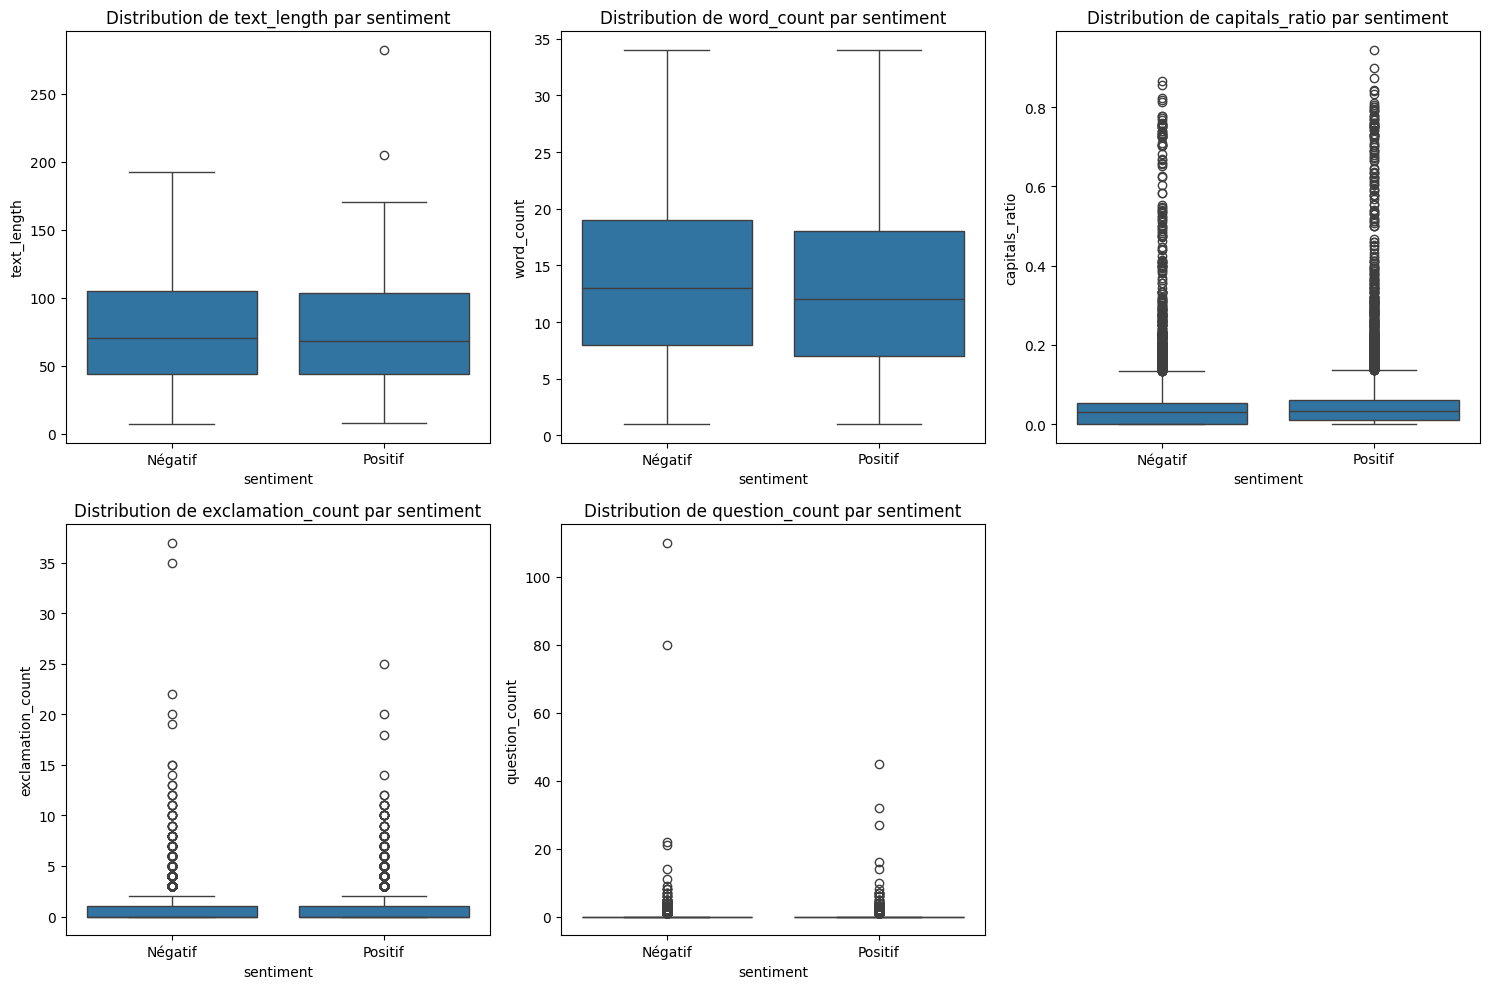

In [14]:
def identifier_caracteristiques_distinctives(df):
    """Identifie les caractéristiques distinctives entre tweets positifs et négatifs"""
    print("\n5. CARACTÉRISTIQUES DISTINCTIVES")
    print("-" * 50)
    
    # Créer un échantillon équilibré pour l'analyse
    neg_samples = df[df['sentiment'] == 'Négatif'].sample(10000, random_state=42)
    pos_samples = df[df['sentiment'] == 'Positif'].sample(10000, random_state=42)
    
    balanced_df = pd.concat([neg_samples, pos_samples])
    
    # Calculer des caractéristiques supplémentaires
    balanced_df['capitals_ratio'] = balanced_df['text'].apply(
        lambda x: sum(1 for c in str(x) if c.isupper()) / len(str(x)) if len(str(x)) > 0 else 0
    )
    
    balanced_df['exclamation_count'] = balanced_df['text'].apply(
        lambda x: str(x).count('!')
    )
    
    balanced_df['question_count'] = balanced_df['text'].apply(
        lambda x: str(x).count('?')
    )
    
    # Comparer les moyennes
    features = ['text_length', 'word_count', 'capitals_ratio', 'exclamation_count', 'question_count']
    
    for feature in features:
        neg_mean = balanced_df[balanced_df['sentiment'] == 'Négatif'][feature].mean()
        pos_mean = balanced_df[balanced_df['sentiment'] == 'Positif'][feature].mean()
        
        print(f"Moyenne de '{feature}':")
        print(f"- Tweets négatifs: {neg_mean:.4f}")
        print(f"- Tweets positifs: {pos_mean:.4f}")
        print(f"- Différence: {abs(pos_mean - neg_mean):.4f}")
        print()
    
    # Visualisation
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(features, 1):
        plt.subplot(2, 3, i)
        sns.boxplot(x='sentiment', y=feature, data=balanced_df)
        plt.title(f'Distribution de {feature} par sentiment')
    
    plt.tight_layout()
    plt.show()

identifier_caracteristiques_distinctives(df)

### Analyse des utilisateurs

- Distribution des tweets par utilisateur
- Tendances de sentiment par utilisateur

In [15]:
def analyser_utilisateurs(df):
    """Analyse la distribution des utilisateurs"""
    print("\n6. ANALYSE DES UTILISATEURS")
    print("-" * 50)
    
    # Nombre total d'utilisateurs uniques
    unique_users = df['user'].nunique()
    print(f"Nombre d'utilisateurs uniques: {unique_users:,}")
    
    # Top utilisateurs par nombre de tweets
    top_users = df['user'].value_counts().head(10)
    print("\nTop 10 des utilisateurs par nombre de tweets:")
    for user, count in top_users.items():
        print(f"- {user}: {count} tweets")
    
    # Distribution des sentiments par utilisateur (pour les utilisateurs avec plus de X tweets)
    min_tweets = 5
    user_sentiment = df.groupby('user')['sentiment'].value_counts().unstack().fillna(0)
    user_sentiment = user_sentiment[user_sentiment.sum(axis=1) >= min_tweets]
    
    # Calculer les ratios
    user_sentiment['total'] = user_sentiment.sum(axis=1)
    user_sentiment['pos_ratio'] = user_sentiment['Positif'] / user_sentiment['total']
    user_sentiment['neg_ratio'] = user_sentiment['Négatif'] / user_sentiment['total']
    
    # Afficher quelques statistiques
    print(f"\nParmi les utilisateurs avec au moins {min_tweets} tweets:")
    print(f"Ratio positif moyen: {user_sentiment['pos_ratio'].mean():.2%}")
    print(f"Ratio négatif moyen: {user_sentiment['neg_ratio'].mean():.2%}")
    
    # Utilisateurs les plus positifs/négatifs
    most_positive = user_sentiment.sort_values('pos_ratio', ascending=False).head(5)
    most_negative = user_sentiment.sort_values('neg_ratio', ascending=False).head(5)
    
    print("\nUtilisateurs les plus positifs:")
    for user, row in most_positive.iterrows():
        print(f"- {user}: {row['pos_ratio']:.2%} positif ({int(row['total'])} tweets)")
    
    print("\nUtilisateurs les plus négatifs:")
    for user, row in most_negative.iterrows():
        print(f"- {user}: {row['neg_ratio']:.2%} négatif ({int(row['total'])} tweets)")

analyser_utilisateurs(df)


6. ANALYSE DES UTILISATEURS
--------------------------------------------------
Nombre d'utilisateurs uniques: 659,775

Top 10 des utilisateurs par nombre de tweets:
- lost_dog: 549 tweets
- webwoke: 345 tweets
- tweetpet: 310 tweets
- SallytheShizzle: 281 tweets
- VioletsCRUK: 279 tweets
- mcraddictal: 276 tweets
- tsarnick: 248 tweets
- what_bugs_u: 246 tweets
- Karen230683: 238 tweets
- DarkPiano: 236 tweets

Parmi les utilisateurs avec au moins 5 tweets:
Ratio positif moyen: 51.23%
Ratio négatif moyen: 48.77%

Utilisateurs les plus positifs:
- 007wisdom: 100.00% positif (6 tweets)
- LongandLoud: 100.00% positif (6 tweets)
- LoopNashville: 100.00% positif (8 tweets)
- Looyda: 100.00% positif (5 tweets)
- LoraNorton: 100.00% positif (5 tweets)

Utilisateurs les plus négatifs:
- zombiemovies: 100.00% négatif (5 tweets)
- zombiecommand: 100.00% négatif (5 tweets)
- zzkim: 100.00% négatif (5 tweets)
- 1284forever: 100.00% négatif (6 tweets)
- 123katie123: 100.00% négatif (5 tweets)


### Analyse des requêtes (flag)

- Impact des requêtes sur la distribution des sentiments
- Requêtes les plus fréquentes

In [16]:
def analyser_requetes(df):
    """Analyse les requêtes utilisées pour collecter les tweets"""
    print("\n7. ANALYSE DES REQUÊTES")
    print("-" * 50)
    
    # Distribution des valeurs de 'flag'
    flag_counts = df['flag'].value_counts()
    print("Distribution des requêtes:")
    print(flag_counts.head(10))
    
    # Pourcentage de tweets sans requête
    no_query_pct = flag_counts.get('NO_QUERY', 0) / len(df) * 100
    print(f"\nPourcentage de tweets sans requête: {no_query_pct:.2f}%")
    
    # Analyse des sentiments par requête
    query_sentiment = df.groupby('flag')['sentiment'].value_counts().unstack().fillna(0)
    
    # Calculer les ratios pour les requêtes les plus fréquentes
    top_queries = flag_counts.head(20).index
    query_sentiment = query_sentiment.loc[top_queries]
    query_sentiment['total'] = query_sentiment.sum(axis=1)
    query_sentiment['pos_ratio'] = query_sentiment['Positif'] / query_sentiment['total']
    query_sentiment['neg_ratio'] = query_sentiment['Négatif'] / query_sentiment['total']
    
    # Afficher les requêtes les plus positives/négatives
    query_sentiment = query_sentiment.sort_values('pos_ratio', ascending=False)
    
    print("\nRequêtes les plus positives:")
    for query, row in query_sentiment.head(5).iterrows():
        print(f"- {query}: {row['pos_ratio']:.2%} positif ({int(row['total'])} tweets)")
    
    print("\nRequêtes les plus négatives:")
    for query, row in query_sentiment.sort_values('pos_ratio').head(5).iterrows():
        print(f"- {query}: {row['neg_ratio']:.2%} négatif ({int(row['total'])} tweets)")

analyser_requetes(df)


7. ANALYSE DES REQUÊTES
--------------------------------------------------
Distribution des requêtes:
flag
NO_QUERY    1600000
Name: count, dtype: int64

Pourcentage de tweets sans requête: 100.00%

Requêtes les plus positives:
- NO_QUERY: 50.00% positif (1600000 tweets)

Requêtes les plus négatives:
- NO_QUERY: 50.00% négatif (1600000 tweets)


### Analyse l'impact de tokens spécifiques sur le sentiment

- Mentions (@)
- URLs (http)
- Hashtags (#)
- Ponctuation (!, ?, ...)
- Émoticônes (:), :()
- Pronoms (I, you, we, they)


8. ANALYSE DE TOKENS SPÉCIFIQUES
--------------------------------------------------
Présence de tokens spécifiques par sentiment:
Token '@':
- Dans tweets positifs: 55.15%
- Dans tweets négatifs: 38.15%
- Différence: 17.00%

Token '!':
- Dans tweets positifs: 35.38%
- Dans tweets négatifs: 24.79%
- Différence: 10.59%

Token 'you':
- Dans tweets positifs: 21.96%
- Dans tweets négatifs: 11.82%
- Différence: 10.14%

Token 'I':
- Dans tweets positifs: 32.57%
- Dans tweets négatifs: 39.74%
- Différence: 7.17%

Token '...':
- Dans tweets positifs: 12.42%
- Dans tweets négatifs: 16.13%
- Différence: 3.71%

Token 'we':
- Dans tweets positifs: 18.74%
- Dans tweets négatifs: 15.87%
- Différence: 2.87%

Token 'http':
- Dans tweets positifs: 5.78%
- Dans tweets négatifs: 3.00%
- Différence: 2.78%

Token 'they':
- Dans tweets positifs: 1.77%
- Dans tweets négatifs: 2.48%
- Différence: 0.71%

Token '#':
- Dans tweets positifs: 2.64%
- Dans tweets négatifs: 1.97%
- Différence: 0.67%

Token '?':
- Da

<Figure size 1200x800 with 0 Axes>

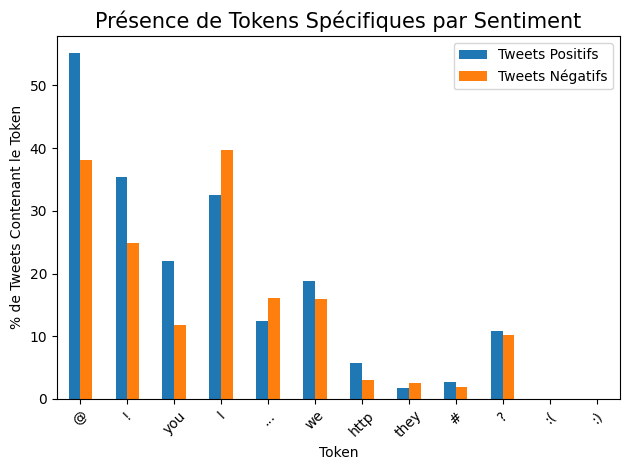

In [17]:
def analyser_tokens_specifiques(df):
    """Analyse l'impact de tokens spécifiques sur le sentiment"""
    print("\n8. ANALYSE DE TOKENS SPÉCIFIQUES")
    print("-" * 50)
    
    # Liste de tokens intéressants à analyser
    tokens_to_analyze = [
        '@', 'http', '#',              # Mentions, URLs, hashtags
        '!', '?', '...', ':)', ':(',   # Ponctuation et émoticônes
        'I', 'you', 'we', 'they'       # Pronoms
    ]
    
    results = {}
    for token in tokens_to_analyze:
        # Vérifier présence du token
        df[f'has_{token}'] = df['text'].astype(str).apply(lambda x: token in x)
        
        # Calculer les pourcentages par sentiment
        pos_with = df[(df['sentiment'] == 'Positif') & (df[f'has_{token}'] == True)].shape[0]
        pos_total = df[df['sentiment'] == 'Positif'].shape[0]
        pos_pct = pos_with / pos_total * 100 if pos_total > 0 else 0
        
        neg_with = df[(df['sentiment'] == 'Négatif') & (df[f'has_{token}'] == True)].shape[0]
        neg_total = df[df['sentiment'] == 'Négatif'].shape[0]
        neg_pct = neg_with / neg_total * 100 if neg_total > 0 else 0
        
        results[token] = {
            'pos_pct': pos_pct,
            'neg_pct': neg_pct,
            'diff': abs(pos_pct - neg_pct)
        }
    
    # Afficher les résultats
    print("Présence de tokens spécifiques par sentiment:")
    for token, stats in sorted(results.items(), key=lambda x: x[1]['diff'], reverse=True):
        print(f"Token '{token}':")
        print(f"- Dans tweets positifs: {stats['pos_pct']:.2f}%")
        print(f"- Dans tweets négatifs: {stats['neg_pct']:.2f}%")
        print(f"- Différence: {stats['diff']:.2f}%")
        print()
    
    # Visualisation
    tokens_df = pd.DataFrame(results).T
    tokens_df = tokens_df.sort_values('diff', ascending=False)
    
    plt.figure(figsize=(12, 8))
    tokens_df[['pos_pct', 'neg_pct']].plot(kind='bar')
    plt.title('Présence de Tokens Spécifiques par Sentiment', fontsize=15)
    plt.xlabel('Token')
    plt.ylabel('% de Tweets Contenant le Token')
    plt.legend(['Tweets Positifs', 'Tweets Négatifs'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

analyser_tokens_specifiques(df)

### Recommandations pour le prétraitement

- Nettoyage du texte
- Tokenisation adaptée à Twitter
- Gestion des mentions, hashtags et URLs

Pour mettre en œuvre ces recommandations, voici un exemple de prétraitement :

1. Conversion en minuscules pour uniformiser le texte
2. Suppression des URLs (pattern 'http' fréquent dans les tweets)
3. Gestion des mentions (@utilisateur) : les supprimer ou les remplacer par un token générique
4. Gestion des hashtags (#sujet) : les conserver sans le symbole # car ils contiennent souvent des informations pertinentes
5. Suppression des caractères spéciaux et de la ponctuation (sauf éventuellement ! et ? qui semblent avoir une corrélation avec le sentiment)
6. Tokenisation adaptée à Twitter (qui gère les émoticônes, abréviations, etc.)
7. Suppression des stopwords (mots très fréquents sans valeur sémantique forte)
8. Normalisation des mots (lemmatisation ou stemming)
9. Traitement des contractions (can't → cannot, etc.)
10. Création de caractéristiques spécifiques : présence d'émoticônes, ponctuation multiple, utilisation de majuscules

In [18]:
def recommandations_preprocesing(df):
    """Propose des recommandations pour le prétraitement"""
    print("\n9. RECOMMANDATIONS POUR LE PRÉTRAITEMENT")
    print("-" * 50)
    
    # Exemples de tweets avant prétraitement
    print("Exemples de tweets avant prétraitement:")
    for i, text in enumerate(df['text'].sample(3, random_state=42), 1):
        print(f"Exemple {i}: {text}")
        
    # Exemple de fonction de prétraitement
    def preprocess_tweet(text):
        # Convertir en minuscules
        text = text.lower()
        # Supprimer les URLs
        text = re.sub(r'http\S+', '', text)
        # Supprimer les mentions
        text = re.sub(r'@\w+', '', text)
        # Gérer les hashtags (garder le texte sans #)
        text = re.sub(r'#(\w+)', r'\1', text)
        # Supprimer la ponctuation et les caractères spéciaux (sauf ! et ?)
        text = re.sub(r'[^\w\s!?]', '', text)
        # Gérer les espaces multiples
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    
    # Exemple de tweets après prétraitement
    print("\nExemples après prétraitement:")
    for i, text in enumerate(df['text'].sample(3, random_state=42), 1):
        processed = preprocess_tweet(text)
        print(f"Exemple {i}:")
        print(f"- Avant: {text}")
        print(f"- Après: {processed}")
        print()

recommandations_preprocesing(df)


9. RECOMMANDATIONS POUR LE PRÉTRAITEMENT
--------------------------------------------------
Exemples de tweets avant prétraitement:
Exemple 1: @chrishasboobs AHHH I HOPE YOUR OK!!! 
Exemple 2: @misstoriblack cool , i have no tweet apps  for my razr 2
Exemple 3: @TiannaChaos i know  just family drama. its lame.hey next time u hang out with kim n u guys like have a sleepover or whatever, ill call u

Exemples après prétraitement:
Exemple 1:
- Avant: @chrishasboobs AHHH I HOPE YOUR OK!!! 
- Après: ahhh i hope your ok!!!

Exemple 2:
- Avant: @misstoriblack cool , i have no tweet apps  for my razr 2
- Après: cool i have no tweet apps for my razr 2

Exemple 3:
- Avant: @TiannaChaos i know  just family drama. its lame.hey next time u hang out with kim n u guys like have a sleepover or whatever, ill call u
- Après: i know just family drama its lamehey next time u hang out with kim n u guys like have a sleepover or whatever ill call u



### Recommandations de modélisation

Approches recommandées pour l'analyse de sentiment:

1. Approches classiques de Machine Learning:
   - Modèles basés sur les sacs de mots (BoW) ou TF-IDF avec classifieurs comme SVM, Random Forest ou Naive Bayes
   - Avantages: rapides à entraîner, interprétables
   - Inconvénients: ne capturent pas la sémantique et l'ordre des mots

2. Word Embeddings + Classifieurs:
   - Utiliser des embeddings pré-entraînés (Word2Vec, GloVe, FastText) avec des classifieurs ML
   - Avantages: capture la sémantique des mots, gère les mots hors vocabulaire (FastText)
   - Inconvénients: perd l'information de séquence

3. Réseaux de neurones récurrents (RNN, LSTM, GRU):
   - Avantages: capture l'information séquentielle, efficace pour le texte
   - Inconvénients: temps d'entraînement plus long, risque de surapprentissage

4. Modèles transformers (BERT, RoBERTa, DistilBERT):
   - Fine-tuning de modèles pré-entraînés spécifiques à Twitter comme BERTweet
   - Avantages: état de l'art en NLP, capture le contexte bidirectionnel
   - Inconvénients: coûteux en ressources, complexe à déployer

5. Approches d'ensemble:
   - Combiner plusieurs modèles pour obtenir de meilleures performances
   - Avantages: souvent meilleures performances, plus robuste
   - Inconvénients: complexité accrue, temps d'inférence plus long

Considérations importantes:

1. Déséquilibre des classes: utiliser des techniques comme SMOTE, sous-échantillonnage, ou pondération des classes
2. Validation croisée: essentielle pour évaluer correctement les performances
3. Métriques d'évaluation: ne pas se limiter à l'accuracy, utiliser F1-score, précision, rappel, et AUC-ROC
4. Interprétabilité: pour certaines applications, privilégier des modèles interprétables ou utiliser SHAP/LIME
5. Dépendance temporelle: considérer l'évolution du langage sur Twitter au fil du temps